# Retrain the de novo model with a seed

<b> What is our goal? <b>

The main goal is to develop a model that has meaningful uncertainty, meaning the uncertainty is low for known and biologically uninteresting classes, but high for unknown and ideally biologically interesting classes. Our hope would be that this new model learns something the original classifier (autophagy_2_1 from SPACRSpy) did not, thereby identifying something new.
The way to test this for the multi-class classifier is by leaving out different biological conditions during training and then checking uncertainty on them as well as by evaluate the new model with screening data, plotting its 8th layer in UMAP and investigating the classifcation scores between the old and new models.


<b> What data do we have now? <b>

1. Stimulated 14h (or 16h) -> labelled as 0
2. Unstimulated -> labelled as 1
3. ATG5 KO (stimulated but that doesn’t matter, this KO supersedes the stim status [probably looks like unstimulated data]) -> labelled as 2
4. Stimulated timecourse data -> labelled as 3
5. EI24 KO timecourse data (more similar to unstim) -> labelled as 4
6. Screening data (similar to stim) -> labelled as 5


<b> What are we doing in this section? <b>

We randomly sample 75,000 instances per class (e.g., 0 and 2 in the first case), train the de novo classifier on this subset and save the resulting model. 


In [1]:
!pip install torch-intermediate-layer-getter
!pip install umap-learn
!pip install leidenalg
!pip install scanpy==1.9.6
!pip install anndata umap-learn
!pip install watermark

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Created wheel for torch-intermediate-layer-getter: filename=torch_intermediate_layer_getter-0.1.post1-py3-none-any.whl size=3724 sha256=d23cee0c5fea6142e1a3fba488e85c692bc4855c516010a87ebb65d7051bb27a
  Stored in directory: /tmp/pip-ephem-wheel-cache-7962veem/wheels/6a/11/c0/30d81aa26172d10d68ffaf352b0762eb9fe0a5f5dcf3de63e0
Successfully built torch-intermediate-layer-getter
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 2.0 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 26.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgr

In [2]:
!pip install nexusformat

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 79 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 45.6 MB 5.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [1]:
#%load_ext watermark
 
import os
import wandb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score
import sys
import seaborn as sn
from torch.utils.tensorboard import SummaryWriter
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
import umap
import scanpy as sc
import anndata as ad
import re
from collections import Counter
import random
from torch.utils.data import Subset
import h5py
import random
import pickle
import glob

from sparcscore.ml.datasets import HDF5SingleCellDataset
# from sparcscore.pipeline.project import TimecourseProject, Project
# from sparcscore.pipeline.workflows import MultithreadedWGATimecourseSegmentation, WGATimecourseSegmentation, MultithreadedCytosolCellposeTimecourseSegmentation, ShardedWGASegmentation, ShardedDAPISegmentationCellpose, WGASegmentation, DAPISegmentationCellpose
from sparcscore.pipeline.extraction import HDF5CellExtraction, TimecourseHDF5CellExtraction
from sparcscore.pipeline.classification import MLClusterClassifier
from sparcscore.ml.pretrained_models import autophagy_classifier2_1

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/u

NOTE! Installing ujson may make loading annotations faster.


## I. Load in full data and big and small test sets <a class="anchor" id="test-set"></a>

In [2]:
full_hdf5_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_B004/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_D001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_F003/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_H002/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_0d.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_4h.h5'],
    dir_labels=[4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 3426407
0: 407464
1: 209030
2: 400000
3: 9346
4: 7476
5: 2393091


In [3]:
from torch.utils.data import Dataset
import torch
import numpy as np
import random
import os
import h5py
   
class HDF5SingleCellDataset(Dataset):
    """
    Class for handling SPARCSpy single cell datasets stored in HDF5 files.

    This class provides a convenient interface for SPARCSpy formated hdf5 files containing single cell datasets. It supports loading data
    from multiple hdf5 files within specified directories, applying transformations on the data, and returning
    the required information, such as label or id, along with the single cell data.

    Attributes
    ----------
    root_dir : str
        Root directory where the hdf5 files are located.
    dir_labels : list of int
        List of labels corresponding to the directories in dir_list.
    dir_list : list of str
        List of path(s) where the hdf5 files are stored. Supports specifying a path to a specific hdf5 file or directory
        containing hdf5 files.
    transform : callable, optional
        A optional user-defined function to apply transformations to the data. Default is None.
    max_level : int, optional
        Maximum levels of directory to search for hdf5 files. Default is 5.
    return_id : bool, optional
        Whether to return the index of the cell with the data. Default is False.
    return_fake_id : bool, optional
        Whether to return a fake index (0) with the data. Default is False.
    select_channel : int, optional
        Specify a specific channel to select from the data. Default is None, which returns all channels.

    Methods
    -------
    add_hdf_to_index(current_label, path)
        Adds single cell data from the hdf5 file located at ‘path’ with the specified ‘current_label’ to the index.
    scan_directory(path, current_label, levels_left)
        Scans directories for hdf5 files and adds their data to the index with the specified ‘current_label’.
    stats()
        Prints dataset statistics including total count and count per label.
    len()
        Returns the total number of single cells in the dataset.
    getitem(idx)
        Returns the data, label, and optional id/fake_id of the single cell specified by the index ‘idx’.

    Examples
    --------
    >>> hdf5_data = HDF5SingleCellDataset(dir_list=[‘data1.hdf5’, ‘data2.hdf5’],
    dir_labels=[0, 1],
    root_dir=‘/path/to/data’,
    transform=None,
    return_id=True)
    >>> len(hdf5_data)
    2000
    >>> sample = hdf5_data[0]
    >>> sample[0].shape
    torch.Size([1, 128, 128])
    >>> sample[1]
    tensor(0)
    >>> sample[2]
    tensor(0)

    """
    
    HDF_FILETYPES = ["hdf", "hf", "h5", "hdf5"]
    def __init__(self, dir_list, 
                 dir_labels, 
                 root_dir, 
                 max_level=5, 
                 transform=None, 
                 return_id=False, 
                 return_fake_id=False,
                 select_channel=None):
        
        self.root_dir = root_dir
        self.dir_labels = dir_labels
        self.dir_list = dir_list
        self.transform = transform
        
        self.handle_list = []
        self.data_locator = []
        
        self.select_channel = select_channel
        
        # scan all directoreis
        for i, directory in enumerate(dir_list):
            path = os.path.join(self.root_dir, directory)  
            current_label = self.dir_labels[i]

            #check if "directory" is a path to specific hdf5
            filetype = directory.split(".")[-1]
            filename = directory.split(".")[0]
                
            if filetype in self.HDF_FILETYPES:
                self.add_hdf_to_index(current_label, directory)

            else:
                # recursively scan for files
                self.scan_directory(path, current_label, max_level)
        
        # print dataset stats at the end
        
        self.return_id = return_id
        self.return_fake_id = return_fake_id
        self.stats()
 
        
    def add_hdf_to_index(self, current_label, path):       
        try:
            input_hdf = h5py.File(path, 'r')
            index_handle = input_hdf.get('single_cell_index')

            handle_id = len(self.handle_list)
            self.handle_list.append(input_hdf.get('single_cell_data'))

            for row in index_handle:
                self.data_locator.append([current_label, handle_id]+list(row))      
        except:
            return
        
    def scan_directory(self, path, current_label, levels_left):
        
        # iterates over all files and folders in a directory
        # hdf5 files are added to the index
        # subfolders are recursively scanned
        
        if levels_left > 0:
            
            # get files and directories at current level
            input_list = os.listdir(path)
            current_level_directories = [os.path.join(path, name) for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

            current_level_files = [ name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]
                        
            for i, file in enumerate(current_level_files):
                filetype = file.split(".")[-1]
                filename = file.split(".")[0]
                
                if filetype in self.HDF_FILETYPES:
                    
                    self.add_hdf_to_index(current_label, os.path.join(path, file))
                    
            # recursively scan subdirectories        
            for subdirectory in current_level_directories:
                self.scan_directory(subdirectory, current_label, levels_left-1)
            
        else:
            return
        
    def stats(self):
    
        labels = [el[0] for el in self.data_locator]
        
        print("Total: {}".format(len(labels)))
        
        for l in set(labels):
            print("{}: {}".format(l,labels.count(l)))
        
    def __len__(self):
        return len(self.data_locator)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # get the label, filename and directory for the current dataset
        data_info = self.data_locator[idx]
        
        if self.select_channel is not None:
            cell_tensor = self.handle_list[data_info[1]][data_info[2], self.select_channel]
            t = torch.from_numpy(cell_tensor)
            t = torch.unsqueeze(t,0)
            
        else:
            
            cell_tensor = self.handle_list[data_info[1]][data_info[2]]
            t = torch.from_numpy(cell_tensor)
            
        t = t.float()     
        
        if self.transform:
            t = self.transform(t)
        """  
        if not list(t.shape) == list(torch.Size([1,128,128])):
            t = torch.zeros((1,128,128))
        """      
        if self.return_id and self.return_fake_id:
            raise ValueError("either return_id or return_fake_id should be set")
            
        if self.return_id:
            
            ids = int(data_info[3])
            sample = (t, torch.tensor(data_info[0]), torch.tensor(ids))
        elif self.return_fake_id:
            
            sample = (t, torch.tensor(data_info[0]), torch.tensor(0))
        else:
            sample = (t, torch.tensor(data_info[0]))
        
        return sample

In [4]:
full_testset_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_A002/single_cells.h5', 
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_B004/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_01_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_4h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_4h.h5',
             ],
    dir_labels=[4, 4, 5, 5, 2, 0, 1, 3, 3], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 1068071
0: 100000
1: 100000
2: 100000
3: 2459
4: 2608
5: 763004


From full_hdf5_data only the first (few) files are used for building the independant, full and unbalanced testset. For the full unbalanced trainset we take all other files except the first one which was used for creating the testset.

In [5]:
case1_full_trainset_data = HDF5SingleCellDataset(
    dir_list=['/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_EI24KO_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_D001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_F003/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_H002/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231004_autophagy_screen_6slides/2.3_K001/single_cells.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_Cr203_C6_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_Cr203_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.2_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_2.3_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_stim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_14h.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/T_02_unstim_wt_filtered.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0316_EI24_fixed_tc/231018_0316_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_0d.h5',
              '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0317_EI24_fixed_tc/231018_0317_EI24_fixed_tc_WT_2_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_1_4h.h5',
             '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/231018_EI24_timecourse_phenix/231018_0318_EI24_fixed_tc/231018_0318_EI24_fixed_tc_WT_2_4h.h5'
             ],
    dir_labels=[4, 4, 4, 4, 5, 5, 5, 5, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3], 
    root_dir='/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93kux/230714_autophagy_training_data_sample/',
    select_channel=4,  # Select the 5th channel (channel index 4)
    return_id=False
)

Total: 2358336
0: 307464
1: 109030
2: 300000
3: 6887
4: 4868
5: 1630087


In [6]:
import torch
from torch.utils.data import DataLoader
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt

def undersample_dataset(dataset, target_classes, n_instances=None, seed=None):
    """
    Undersamples the dataset so target_classes have equal number of instances.
    If n_instances is set, each class will have n_instances samples.
    
    Parameters:
    - dataset: PyTorch Dataset object containing the features (e.g., HDF5SingleCellDataset)
    - target_classes: the list of classes to undersample (e.g., [0, 2] for training)
    - n_instances: number of samples per class (None means use minimum of class sizes)
    - seed: random seed for reproducibility
    
    Returns:
    - undersampled_dataset: the undersampled dataset (list of samples)
    """
    np.random.seed(seed)
    undersampled_data = []
    
    for cls in target_classes:
        class_indices = [i for i, (_, label) in enumerate(dataset) if label == cls]
        if n_instances is None:
            n_instances = len(class_indices)
        
        # Randomly sample n_instances for each class
        sampled_indices = np.random.choice(class_indices, n_instances, replace=False)
        undersampled_data.extend([dataset[i] for i in sampled_indices])
    
    # Shuffle the dataset
    undersampled_data = shuffle(undersampled_data, random_state=seed)
    return undersampled_data

# Function to create balanced testset for classes 0-5
def create_balanced_testset(dataset, target_classes, n_instances_per_class):
    """
    Create a balanced testset with n_instances_per_class for each class in target_classes.
    
    Parameters:
    - dataset: PyTorch Dataset object (e.g., HDF5SingleCellDataset)
    - target_classes: list of classes (e.g., [0, 1, 2, 3, 4, 5])
    - n_instances_per_class: number of instances to sample per class
    
    Returns:
    - balanced_testset: list of samples with balanced instances per class
    """
    balanced_data = []
    
    for cls in target_classes:
        print(cls)
        class_indices = [i for i, (_, label) in enumerate(dataset) if label == cls]
        # Randomly sample n_instances_per_class for each class
        sampled_indices = np.random.choice(class_indices, n_instances_per_class, replace=False)
        balanced_data.extend([dataset[i] for i in sampled_indices])
    
    # Shuffle balanced testset
    balanced_data = shuffle(balanced_data, random_state=42)  # Fixed seed for test set
    return balanced_data

In [7]:
# Function to save dataset as torch tensor
def save_dataset(dataset, labels, save_path):
    # Convert the dataset to a single tensor (stack the data)
    images_tensor = torch.stack([dataset[i][0] for i in range(len(dataset))])
    labels_tensor = torch.tensor(labels)

    # Save the tensors
    torch.save((images_tensor, labels_tensor), save_path)
    print(f"Dataset saved at {save_path}")

In [8]:
# Function to load saved dataset and recreate DataLoader
def load_dataset(save_path, batch_size):
    # Load the saved tensor data
    images_tensor, labels_tensor = torch.load(save_path)
    
    # Create a TensorDataset from the loaded tensors
    dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor)
    
    # Create DataLoader
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    print(f"Loaded dataset from {save_path}")
    return data_loader

In [9]:
seeds = [1]   # Different seeds for ensembling
batch_size = 256                    # Batch size for DataLoader

In [10]:
# 1. Create balanced testset for classes 0-5 (fixed across all training processes)
n_test_instances_per_class = 2000    # Test instances for each class (0-5)

target_test_classes = [0, 1, 2, 3, 4, 5]
balanced_testset = create_balanced_testset(full_testset_data, target_test_classes, n_test_instances_per_class)

0
1
2
3
4
5


In [14]:
# Create test DataLoader (shared for all training processes)
test_data_loader = DataLoader(balanced_testset, batch_size=batch_size, shuffle=True, num_workers=14, pin_memory=True)

# Print test set class distribution
test_labels = [label for _, label in balanced_testset]
unique, counts = np.unique(test_labels, return_counts=True)
print(f"Test set class distribution (balanced): {dict(zip(unique, counts))}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 5, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test set class distribution (balanced): {0: 2000, 1: 2000, 2: 2000, 3: 2000, 4: 2000, 5: 2000}


In [11]:
# Save the balanced testset and undersampled training sets
balanced_test_labels = [label for _, label in balanced_testset]  # Extracting labels
save_dataset(balanced_testset, balanced_test_labels, "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset.pt")

Dataset saved at /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset.pt


In [ ]:
# 2. Create 5 different training sets with different seeds (for classes 0 and 2)
n_train_instances_per_class = 75000 # Training instances for each class (0 and 2)
train_loaders = []
target_train_classes = [0, 2]  # We only use classes 0 and 2 for training

for seed in seeds:
    print("seed " + str(seed))
    undersampled_trainset = undersample_dataset(case1_full_trainset_data, target_train_classes, 
                                                n_instances=n_train_instances_per_class, seed=seed)
    
    # Create DataLoader for each seed
    train_loader = DataLoader(undersampled_trainset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=14, pin_memory=True)
    train_loaders.append(train_loader)

    # Print train set class distribution
    train_labels = [label for _, label in undersampled_trainset]
    unique, counts = np.unique(train_labels, return_counts=True)
    print(f"Train set class distribution (seed {seed}): {dict(zip(unique, counts))}")

In [ ]:
for i, (trainset, train_labels) in enumerate(zip(train_loaders, seeds)):
    save_dataset(trainset.dataset, train_labels, f"/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/ensemble2_balanced_trainset_case1/undersampled_trainset_seed_{i}.pt")

In [12]:
# Load the balanced testset
test_data_loader = load_dataset("/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset.pt", batch_size)

Loaded dataset from /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset.pt


In [13]:
!ls -l /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/ensemble2_balanced_trainset_case1_small/

total 279360
-rw-rw---- 1 di93quv pn36po 65554048 Sep 17 18:26  trainset_0_seed_42.h5
-rw-rw---- 1 di93quv pn36po 65554048 Sep 17 18:27  trainset_2_seed_42.h5
-rw-rw---- 1 di93quv pn36po 82019584 Sep 29 22:31 'trainset_[0, 2]_seed_42.h5'
-rw-rw---- 1 di93quv pn36po    23113 Sep 29 22:31  trainset_indices_42.pkl
-rw-rw---- 1 di93quv pn36po  1312079 Oct  5 17:51  undersampled_trainset_seed_0.pt
-rw-rw---- 1 di93quv pn36po  1312079 Oct  5 17:51  undersampled_trainset_seed_1.pt
-rw-rw---- 1 di93quv pn36po 13108633 Oct  6 23:03  undersampled_trainset_seed_101.pt
-rw-rw---- 1 di93quv pn36po  1312079 Oct  5 17:51  undersampled_trainset_seed_2.pt
-rw-rw---- 1 di93quv pn36po 13108633 Oct  6 23:03  undersampled_trainset_seed_202.pt
-rw-rw---- 1 di93quv pn36po  1312079 Oct  5 17:51  undersampled_trainset_seed_3.pt
-rw-rw---- 1 di93quv pn36po 13108633 Oct  6 23:03  undersampled_trainset_seed_303.pt
-rw-rw---- 1 di93quv pn36po  1312079 Oct  5 17:51  undersampled_trainset_seed_4.pt
-rw-rw---- 1 di93

In [ ]:
# Load undersampled training sets
train_loaders = []
for i in range(len(seeds)):
    train_loader = load_dataset(f"/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/ensemble2_balanced_trainset_case1_small/undersampled_trainset_seed_{i}.pt", batch_size)
    train_loaders.append(train_loader)

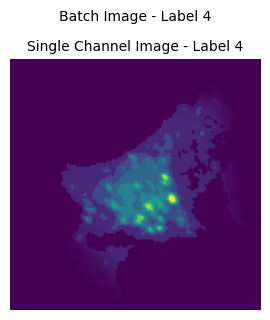

In [14]:
def visualize_batch(data_loader):
    images, labels = next(iter(data_loader)) 

    # Visualize the first image in the batch
    image_data = images[0].numpy() 
    label = labels[0].item()  # Convert label tensor to Python int
    
    num_channels = image_data.shape[0]  # number of channels
    
    if num_channels == 1:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        ax.imshow(image_data[0]) 
        ax.set_title(f"Single Channel Image - Label {label}", fontsize=10)
        ax.axis('off')
    else:
        fig, axes = plt.subplots(1, num_channels, figsize=(10, 5))
        for channel in range(num_channels):
            axes[channel].imshow(image_data[channel])
            axes[channel].set_title(f"Channel {channel + 1}")
            axes[channel].axis('off')
        
    plt.tight_layout()
    plt.suptitle(f"Batch Image - Label {label}", fontsize=10, y=1.05)
    plt.show()

# Visualize a batch from the test DataLoader
visualize_batch(test_data_loader)

# Visualize a batch from one of the train DataLoaders
#visualize_batch(train_loaders[0])

## II. Ensemble 2: Retrain de novo model 5 times on different subsets with dropout at test time <a class="anchor" id="ensemble2"></a>

Here we retrain the de novo multiclass model on a different subset of each class 5 times via random subset for Case 1. This means we take a different 100000 of each class and retrain. Again, similar to ensembling before, we plot the UMAP and look for screening hits and check for overlaps. We also need to ensure that the classes are balanced in training as well.


In [15]:
class MultiClassClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassClassifier, self).__init__()
        
        # VGG-like feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier head for multi-class
        self.fc_input_size = 8192 
        self.classifier = nn.Sequential(
            nn.Linear(self.fc_input_size, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes) 
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        
        # Print the size of x to confirm it's correct
        #print("Size of x:", x.size())
        
        x = self.classifier(x)
        return x

# Create an instance of the model
num_classes = 6
model = MultiClassClassifier(num_classes)
print(model)

MultiClassClassifier(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (

#### Case 1 (train with classes 0,2)


75000 instances per class

In [16]:
# List of seeds for reproducibility
seeds = [1]

# Wandb login
wandb.login()

#load testset once
test_data_loader = load_dataset("/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset.pt", batch_size)

n_train_instances_per_class = 75000  # Training instances for each class (0 and 2)
train_loaders = []
target_train_classes = [0, 2]  # We only use classes 0 and 2 for training


for seed in seeds:
    print(f"Currently running ensemble run for seed {seed}...")
    
    # Set seed for reproducibility
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

    # Redirect print statements to a file (unique for each seed)
    sys.stdout = open(f"ensemble_duplicate_multi_class_output_seed_{seed}.txt", "w")

    # Initialize TensorBoard writer (unique directory for each seed)
    tensorboard_writer = SummaryWriter(f'runs/ensemble_VGG2_autophagy_multi_class_training_seed_{seed}')

    # W&B with unique run name for each seed
    run = wandb.init(project="ensemble_VGG2_autophagy_multi_class_training", name=f'seed_{seed}')

    # Define the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create an instance of model
    num_classes = 6
    model = MultiClassClassifier(num_classes)
    model.to(device)

    # Define the loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 5  
    batch_size = 256 
    log_interval = 50  # Log metrics every 50 batches

    epsilon = 1e-8  # Small epsilon value to prevent log(0) in uncertainties
    
    # 2. Create 5 different training sets with different seeds (for classes 0 and 2)
    undersampled_trainset = undersample_dataset(case1_full_trainset_data, target_train_classes, 
                                                n_instances=n_train_instances_per_class, seed=seed)
    
    # Create DataLoader for each seed
    train_loader = DataLoader(undersampled_trainset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=14, pin_memory=True)
    train_loaders.append(train_loader)

    # Print train set class distribution
    train_labels = [label for _, label in undersampled_trainset]
    unique, counts = np.unique(train_labels, return_counts=True)
    print(f"Train set class distribution (seed {seed}): {dict(zip(unique, counts))}")
    
    stop_training = False

    # Training loop
    for epoch in range(1, num_epochs + 1):
        if stop_training:
            break  

        print("Epoch: ", epoch)
        model.train()  # Set model to training mode

        total_loss = 0.0
        correct = 0
        total_samples = len(train_loader)
        batch_counter = 0  # Reset batch counter at the start of each epoch
        
        #print(len(test_data_loader.dataset))

        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, labels)
            loss.backward() 
            optimizer.step()

            total_loss += loss.sum().item()
            _, predicted = output.max(1)
            correct += predicted.eq(labels).sum().item()

            batch_counter += 1

            # Calculate accuracy and average loss for the current batch
            accuracy = 100.0 * correct / (batch_counter * batch_size)
            average_loss = total_loss / (batch_counter * batch_size)

            # Check for the desired accuracy and stop training if reached
            if accuracy >= 99.0:
                stop_training = True
                print("Accuracy over 99% reached and thus stopping training...")
                break

        # Calculate and log training metrics
        all_train_labels = []
        all_train_predicted = []

        for data, labels in train_loader:
            data = data.to(device)
            labels = labels.to(device)

            output = model(data)
            _, predicted = output.max(1)
            all_train_labels.extend(labels.cpu().numpy())
            all_train_predicted.extend(predicted.cpu().numpy())

        train_precision = precision_score(all_train_labels, all_train_predicted, average='macro')
        train_recall = recall_score(all_train_labels, all_train_predicted, average='macro')
        train_f1 = f1_score(all_train_labels, all_train_predicted, average='macro')
        train_balanced_accuracy = balanced_accuracy_score(all_train_labels, all_train_predicted)

        train_accuracy = accuracy_score(all_train_labels, all_train_predicted) * 100.0

        print("Train Precision: " + str(train_precision) + " Recall: " + str(train_recall) + " F1 score: " + str(train_f1))
        print("Train Balanced Accuracy: {:.2f}%".format(train_balanced_accuracy))

        # Log train metrics for the epoch
        wandb.log({
            "Train Epoch": epoch,
            "Train_Precision": train_precision,
            "Train_Recall": train_recall,
            "Train_F1-score": train_f1,
            "Train_Balanced_Accuracy": train_balanced_accuracy,
            "Train_Loss": average_loss,
        })

        # Log on TensorBoard
        tensorboard_writer.add_scalar('Train_Precision', train_precision, global_step=epoch)
        tensorboard_writer.add_scalar('Train_Recall', train_recall, global_step=epoch)
        tensorboard_writer.add_scalar('Train_F1-score', train_f1, global_step=epoch)
        tensorboard_writer.add_scalar('Train_Balanced_Accuracy', train_balanced_accuracy, global_step=epoch)
        tensorboard_writer.add_scalar('Train_Loss', average_loss, global_step=epoch)

        correct = 0
        total_loss = 0.0

        # Test loop with dropout and aggregated confusion matrix
        model.eval()

        # Enable dropout during testing
        model.apply(lambda m: setattr(m, 'training', True))

        test_correct = 0
        test_average_loss = 0.0
        all_test_labels = []
        all_test_predicted = []
        test_class_uncertainties = [[] for _ in range(num_classes)]

        with torch.no_grad():
            for data, labels in test_data_loader:
                data = data.to(device)
                labels = labels.to(device)

                output = model(data)
                _, predicted = output.max(1)
                test_correct += predicted.eq(labels).sum().item()
                all_test_labels.extend(labels.cpu().numpy())
                all_test_predicted.extend(predicted.cpu().numpy())

                loss = loss_function(output, labels)
                test_average_loss += loss.sum().item()

                # Calculate class probabilities
                probs = torch.nn.functional.softmax(output, dim=1)
                    
                # Calculate uncertainties (entropy) for each sample
                uncertainties = [-torch.sum(p * torch.log(p + epsilon)).item() for p in probs]

                # Accumulate uncertainties for each predicted class
                predicted_classes = predicted.cpu().numpy()  # Predicted classes from output.max(1)

                for idx, pred_class in enumerate(predicted_classes):
                    test_class_uncertainties[pred_class].append(uncertainties[idx])


        # Filter out predictions and labels for classes seen during training
        mask_seen_classes = np.isin(all_test_labels, [0, 2])  # Class 0 and 2 seen at training
        filtered_test_labels = np.array(all_test_labels)[mask_seen_classes]
        filtered_test_predicted = np.array(all_test_predicted)[mask_seen_classes]

        # Calculate accuracy and loss only for the seen classes
        test_accuracy = accuracy_score(filtered_test_labels, filtered_test_predicted)
        test_average_loss = test_average_loss / len(test_data_loader.dataset)

        print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
        print("Test Loss: {:.4f}".format(test_average_loss))

        wandb.log({
            "Test_Accuracy": test_accuracy,
            "Test_Loss": test_average_loss,
        })

        tensorboard_writer.add_scalar('Test_Accuracy', test_accuracy, global_step=epoch)
        tensorboard_writer.add_scalar('Test_Loss', test_average_loss, global_step=epoch)

        # Aggregate and log confusion matrix
        aggregated_confusion = confusion_matrix(all_test_labels, all_test_predicted)

        # Confusion matrix
        epsilon = 1e-8
        df_cm = pd.DataFrame(aggregated_confusion / (np.sum(aggregated_confusion, axis=1)[:, None] + epsilon),
                             index=[i for i in range(num_classes)],
                             columns=[i for i in range(num_classes)])

        # Save confusion matrix to Tensorbboard
        figure = sn.heatmap(df_cm, annot=True).get_figure()
        tensorboard_writer.add_figure(f'Aggregated Confusion Matrix - Epoch {epoch}', figure, global_step=epoch)

        # Set the model back to training mode
        model.train()

        # Plot histogram of uncertainties
        class1_uncertainties = test_class_uncertainties[1]
        plt.hist(class1_uncertainties, bins=50, alpha=0.5, color='blue', label='Class 1 Uncertainties')
        plt.xlabel('Uncertainty')
        plt.ylabel('Frequency')
        plt.title('Uncertainty Distribution for Class 1')
        plt.legend()
        plt.savefig(f'ensemble_uncertainty_histogram_class1_epoch{epoch}_seed_{seed}.png')
        plt.close()

    # Save model (unique for each seed)
    try:
        print(f"Saving final model for seed {seed} now...")
        torch.save(model.state_dict(), f'ensemble_multi_class_VGG2_case1_seed_{seed}.pth')
    except Exception as e:
        print(f"Error saving model for seed {seed}: {str(e)}")

    # Close the W&B run
    wandb.finish()
    
    # Close file and reset stdout
    sys.stdout.close()
    sys.stdout = sys.__stdout__  # Reset to default stdout

    # Close the TensorBoard writer
    tensorboard_writer.close()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marunku (crisprscreen). Use `wandb login --relogin` to force relogin


Loaded dataset from /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/balanced_testset_all_classes/balanced_testset.pt
Currently running ensemble run for seed 1...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 14 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test_Accuracy,▁█
Test_Loss,█▁
Train Epoch,▁█
Train_Balanced_Accuracy,█▁
Train_F1-score,█▁
Train_Loss,█▁
Train_Precision,█▁
Train_Recall,█▁
Test_Accuracy,0.78775
Test_Loss,0.08817
Train Epoch,2


Dataset saved at /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/ensemble2_balanced_trainset_case1/undersampled_trainset_seed_1.pt
total 67168640
-rw-rw---- 1 di93quv pn36po 9830401475 Nov 10 18:45 undersampled_trainset_seed_0.pt
-rw-rw---- 1 di93quv pn36po 9830401475 Nov 10 18:51 undersampled_trainset_seed_1.pt
-rw-rw---- 1 di93quv pn36po 9830401485 Oct  7 01:02 undersampled_trainset_seed_101.pt
-rw-rw---- 1 di93quv pn36po 9830401485 Oct  7 01:03 undersampled_trainset_seed_202.pt
-rw-rw---- 1 di93quv pn36po 9830401485 Oct  7 01:03 undersampled_trainset_seed_303.pt
-rw-rw---- 1 di93quv pn36po 9830401485 Oct  7 01:03 undersampled_trainset_seed_404.pt
-rw-rw---- 1 di93quv pn36po 9830401480 Oct  7 01:02 undersampled_trainset_seed_42.pt
total 67200448
-rw-rw---- 1 di93quv pn36po 9830401475 Nov 10 18:45 undersampled_trainset_seed_0.pt
-rw-rw---- 1 di93quv pn36po 9830401475 Nov 10 18:51 undersampled_trainset_seed_1.pt
-rw-rw---- 1 di93quv pn36po 9830401485 Oct  7 01:02 undersampled_

In [17]:
for i, (trainset, seed) in enumerate(zip(train_loaders, seeds)):
    save_dataset(trainset.dataset, seed, f"/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/ensemble2_balanced_trainset_case1/undersampled_trainset_seed_{seed}.pt")

In [20]:
# Load undersampled training sets
!ls -l /dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93quv/ensemble2_balanced_trainset_case1/

Here we create a new training dataset for every seed and we can modify the loop to generate a new dataset for each seed before retraining on that dataset. This way, the model is retrained on different subsets of the data for each seed, achieving the desired variation in the training data while keeping the test data constant.